### lstm for stream
Much of this code was adapted from  https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

The data comes from the Global Summary of the Day (GSOD) weather from the National Oceanographic and Atmospheric Administration (NOAA) for 9,000 weather stations.  The three stations are Bellingham Intl, Padilla Bay Reserve and Skagit Regional.  The data has been cleaned up and normalized and loaded in the file si_stations.pkl.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
import pickle
six = pickle.load(open('six_stations.pkl', 'rb'))

In [3]:
np.array(six[0][0:10])[:,1]

array([37.4, 37.4, 39.2, 46.4, 51.8, 55.4, 46.4, 46.4, 46.4, 44.6])

In [4]:
for i in range(6):
    six[i] = np.array(six[i])[:,1]
sixave = np.zeros(360)
for i in range(6):
    sixave += six[i][:360]
sixave = sixave/6.0

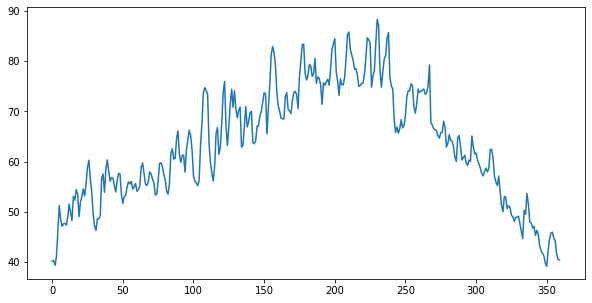

In [5]:
sixave
plt.figure( figsize=(10,5))
plt.plot(sixave)


In [6]:
class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 100)
        self.linear = nn.Linear(100, 1)
        self.c_h = (torch.zeros(1,1,100),
                    torch.zeros(1,1,100))
    def forward(self, x):
        h, self.c_h= self.lstm(x.view(len(x) ,1, -1), self.c_h)
        predictions = self.linear(h.view(len(x), -1))
        return predictions[-1]

In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(sixave.reshape(-1, 1))
train_six_normalized =[]

In [61]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 7

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

we now add the data from stations 1 and 2 to the average to make the training set.

In [62]:
for i in range(1,2):
    scaler = MinMaxScaler(feature_range=(-1, 1))    
    train_data_normalized2 = scaler.fit_transform(six[i].reshape(-1, 1))
    train_data_normalized2 = torch.FloatTensor(train_data_normalized2).view(-1)
    train_inout_seq2 = create_inout_sequences(train_data_normalized2, train_window)
    train_inout_seq += train_inout_seq2

In [74]:
## invoke this step if you wish to train the model.
## if you just want to loa the pretrained model go to the next step
model = MyLSTM()
loss_function = nn.MSELoss()
hidden_layer_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs =2002 #52

for i in range(epochs):
    seq_err = 0.0
    for _ in range(500):
        num = np.random.randint(len(train_inout_seq))
        seq = train_inout_seq[num][0]
        labels = train_inout_seq[num][1]
        optimizer.zero_grad()
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        seq_err+= single_loss.item()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        print(f'seq: {i:3} loss: {seq_err:10.8f}')
    if seq_err < 0.07:
        break

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.03896809
seq:   1 loss: 18.02973754
epoch:  26 loss: 0.00014556
seq:  26 loss: 6.83309739
epoch:  51 loss: 0.00274521
seq:  51 loss: 7.66291119
epoch:  76 loss: 0.03120958
seq:  76 loss: 7.88240884
epoch: 101 loss: 0.04329505
seq: 101 loss: 7.72993722
epoch: 126 loss: 0.06951842
seq: 126 loss: 7.07814998
epoch: 151 loss: 0.00086020
seq: 151 loss: 6.99419068
epoch: 176 loss: 0.02949315
seq: 176 loss: 5.84873695
epoch: 201 loss: 0.05603267
seq: 201 loss: 5.53690916
epoch: 226 loss: 0.01600111
seq: 226 loss: 5.81195380
epoch: 251 loss: 0.00066242
seq: 251 loss: 4.90264043
epoch: 276 loss: 0.00222533
seq: 276 loss: 3.72512790
epoch: 301 loss: 0.00525826
seq: 301 loss: 3.39536033
epoch: 326 loss: 0.00125689
seq: 326 loss: 2.92252480
epoch: 351 loss: 0.00481524
seq: 351 loss: 2.14445123
epoch: 376 loss: 0.04181362
seq: 376 loss: 2.39440818
epoch: 401 loss: 0.00195836
seq: 401 loss: 1.56993124
epoch: 426 loss: 0.00275171
seq: 426 loss: 1.38947741
epoch: 451 loss: 0.00274065

In [72]:
use_saved_model = False
if use_saved_model:
    model = MyLSTM()
    model.load_state_dict(torch.load('lstm-modelave_final')) 
    
save_model = True
if save_model:
    torch.save(model.state_dict(), 'lstm-modelave_newer')


In [83]:
#load the saved model uncoment this one.
model.load_state_dict(torch.load('lstm-modelave_final')) 

<All keys matched successfully>

The following function will take a data set consisting of one year of high temperature readings and create a sliding window of 12 days and invoke the network to get the 13th day.  this predicted 13th day is appended to a list of predictions.  

In [84]:
def OneStep(data):
    print('data set length =', len(data))
    train_window = 7
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))
    fut_pred = len(data) -train_window
    test_inputs = train_data_normalized[0:train_window].reshape(train_window).tolist()
    s2 = train_data_normalized.reshape(len(data)).tolist()
    realdata = data
    model.eval()
    preds = test_inputs.copy()
    t2 = test_inputs
    hidden_layer_size = 100
    x = 0
    for i in range(fut_pred):
        seq = torch.FloatTensor(t2[i:])
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))
        x = model(seq).item()
        #print(seq[-1],s2[train_window+i], x)
        preds.append(x)
        t2.append(s2[train_window+i])  
    actual_predictions = scaler.inverse_transform(np.array(preds ).reshape(-1, 1))

    print(len(actual_predictions))
    plt.figure( figsize=(10,5))
    plt.plot(data)
    plt.plot(actual_predictions[0:])
    err = 0.0
    errs = 0.0
    cnt = 0
    badday  =0.0
    errsq = 0.0
    for i in range(1,len(actual_predictions)):
        err += np.abs(realdata[i-1]-actual_predictions[i])
        errs += np.abs(realdata[i-1]-realdata[i])
        errsq +=(realdata[i-1]-actual_predictions[i])*(realdata[i-1]-actual_predictions[i])
        if (realdata[i-1]-actual_predictions[i]) > 10 or (realdata[i-1]-actual_predictions[i]) < -10:
            badday += np.abs((realdata[i-1]-actual_predictions[i]))
            cnt +=1
    print("mean daily error =", err[0]/360, ' degrees')
    print("mean daily change =", errs/360, ' degrees')
    err = np.sqrt(errsq)/360.0
    print("l2 error=", err)
    print('days where prediction error exceeds 10 degrees =', cnt)
    if cnt > 0:
        print("average error on those days = ", badday/cnt)    
    print('------------------------------------') 
    err = 0.0
    cnt = 0
    badday  =0.0
    errsq = 0.0    
    for i in range(len(actual_predictions)):
        err += np.abs(realdata[i]-actual_predictions[i])
        errsq +=(realdata[i]-actual_predictions[i])*(realdata[i]-actual_predictions[i])
        if (realdata[i]-actual_predictions[i]) > 10 or (realdata[i]-actual_predictions[i]) < -10:
            badday += np.abs((realdata[i]-actual_predictions[i]))
            cnt +=1
    print("mean daily error =", err[0]/360, ' degrees')
    err = np.sqrt(errsq)/360.0
    print("l2 error=", err)
    print('days where prediction error exceeds 10 degrees =', cnt)
    if cnt > 0:
        print("average error on those days = ", badday/cnt)    

data set length = 360
360
mean daily error = 2.077269943746977  degrees
mean daily change = 2.0523611111111126  degrees
l2 error= [0.14954447]
days where prediction error exceeds 10 degrees = 1
average error on those days =  [11.54051163]
------------------------------------
mean daily error = 0.17090499364805334  degrees
l2 error= [0.01213879]
days where prediction error exceeds 10 degrees = 0


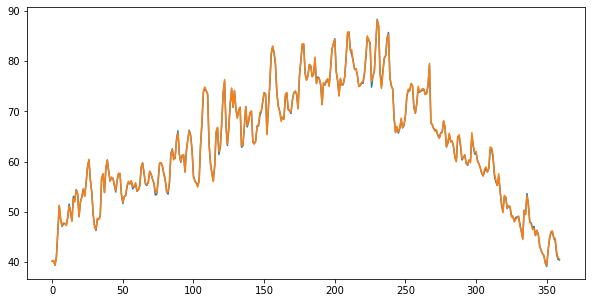

In [85]:
OneStep(sixave)

data set length = 365
365
mean daily error = 2.668634491815334  degrees
mean daily change = 3.0849999999999946  degrees
l2 error= [0.19716346]
days where prediction error exceeds 10 degrees = 8
average error on those days =  [13.24480189]
------------------------------------
mean daily error = 4.036893025947113  degrees
l2 error= [0.29494253]
days where prediction error exceeds 10 degrees = 19
average error on those days =  [15.18822348]


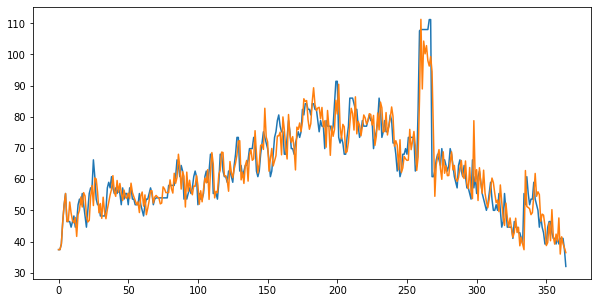

In [86]:
OneStep(six[0])

data set length = 365
365
mean daily error = 3.1205269228729127  degrees
mean daily change = 3.0274999999999985  degrees
l2 error= [0.23554475]
days where prediction error exceeds 10 degrees = 16
average error on those days =  [12.53344305]
------------------------------------
mean daily error = 0.2193874442370445  degrees
l2 error= [0.01498749]
days where prediction error exceeds 10 degrees = 0


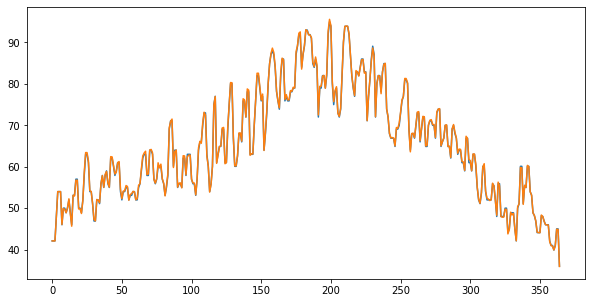

In [87]:
OneStep(six[1])

data set length = 365
365
mean daily error = 2.6334682062392445  degrees
mean daily change = 2.725555555555555  degrees
l2 error= [0.18132669]
days where prediction error exceeds 10 degrees = 4
average error on those days =  [11.39698455]
------------------------------------
mean daily error = 3.231305657492744  degrees
l2 error= [0.22461474]
days where prediction error exceeds 10 degrees = 10
average error on those days =  [12.08119491]


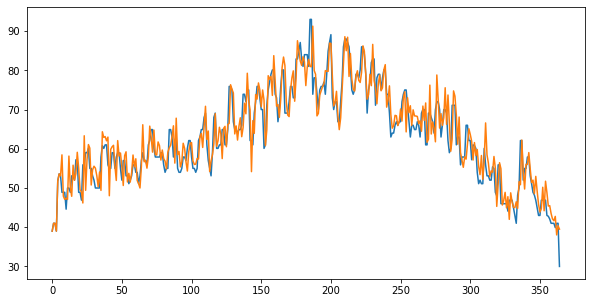

In [78]:
OneStep(six[2])

data set length = 360
360
mean daily error = 2.6163372635655104  degrees
mean daily change = 3.2049999999999943  degrees
l2 error= [0.18498699]
days where prediction error exceeds 10 degrees = 4
average error on those days =  [13.3065269]
------------------------------------
mean daily error = 3.659536803383379  degrees
l2 error= [0.25042075]
days where prediction error exceeds 10 degrees = 15
average error on those days =  [12.08912394]


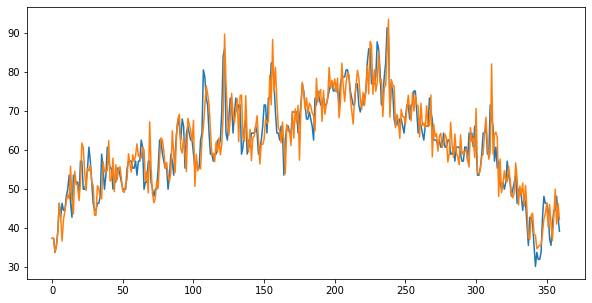

In [79]:
OneStep(six[3])

data set length = 365
365
mean daily error = 2.62632569331055  degrees
mean daily change = 3.042777777777776  degrees
l2 error= [0.17601554]
days where prediction error exceeds 10 degrees = 1
average error on those days =  [12.2208925]
------------------------------------
mean daily error = 3.62062004706719  degrees
l2 error= [0.25801667]
days where prediction error exceeds 10 degrees = 20
average error on those days =  [13.18175686]


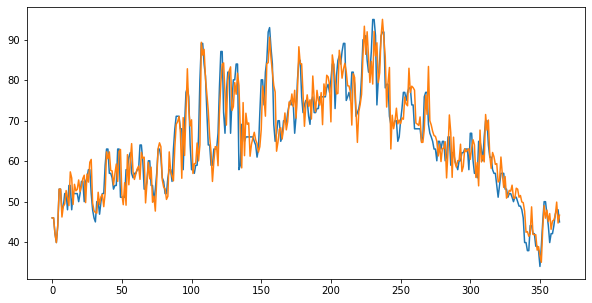

In [80]:
OneStep(six[4])

data set length = 365
365
mean daily error = 2.684698101369559  degrees
mean daily change = 3.0425000000000013  degrees
l2 error= [0.18194985]
days where prediction error exceeds 10 degrees = 2
average error on those days =  [12.80738852]
------------------------------------
mean daily error = 3.822815976320355  degrees
l2 error= [0.26548712]
days where prediction error exceeds 10 degrees = 20
average error on those days =  [12.50349423]


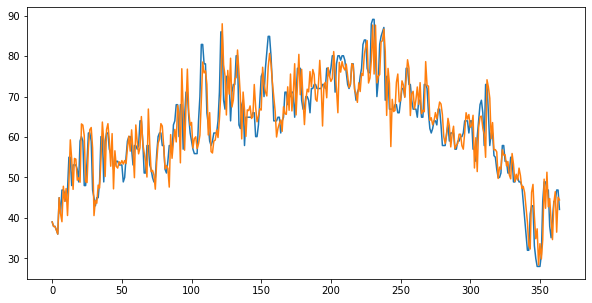

In [81]:
OneStep(six[5])